In [1]:
import pandas as pd
import seaborn as sn
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

### Датасет

In [2]:
df = pd.read_csv("../data/train_features.csv", sep="|")
test = pd.read_csv("../data/test_features.csv", sep="|")
df.head()

,Button.left_dwell,Button.left_interval,Button.left_flight,Key.tab,Key.tab_dwell,Key.tab_interval,Key.tab_flight,Key.shift,Key.shift_dwell,Key.shift_interval,...,тор_dwell_second,тор_dwell_third,тор_interval_first,тор_interval_second,тор_flight_first,тор_flight_second,тор_up_to_up_first,тор_up_to_up_second,тор_latency,is_insider
0,82.18,472.27,469.34,0.572792,86.31,478.56,502.38,7.696897,307.92,178.98,...,115.00,110.75,372.50,563.25,233.25,178.25,237.5,174.00,522.25,0
1,75.87,479.03,460.12,0.000000,0.00,0.00,0.00,4.770889,312.07,203.07,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0
2,10.33,556.47,514.17,6.126238,175.98,477.89,496.30,4.863861,469.23,223.51,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0
3,27.35,464.80,492.16,2.222222,153.42,510.17,413.58,2.962963,375.38,122.50,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0
4,159.12,464.79,492.13,3.385951,182.67,453.64,496.45,2.178374,437.52,482.68,...,203.25,148.75,810.75,973.00,195.00,176.25,264.0,121.75,520.00,0


In [3]:
y = df['is_insider']
x_train, x_test, y_train, y_test = train_test_split(df, y, random_state = 0, test_size = 0.3)
X_test = test
Y_test = test['is_insider']

In [4]:
medians = {} # словарь для хранения медиан для каждого столбца
# заполнение пустот в обучаемой выборке с помощью медиан
# и их использование для заполнения пустот в валидационной выборке
for col in x_train.columns:
    if col != 'is_insider':
        # медианы         
        medians[col + "_non_insider"] = x_train.loc[(x_train[col] != 0) & (x_train['is_insider'] == 0), col].median()
        medians[col + "_is_insider"] = x_train.loc[(x_train[col] != 0) & (x_train['is_insider'] == 1), col].median()
        # заполнение пустот в обучаемой выборке с помощью медиан из обучаемой выборки
        x_train.loc[(x_train[col] == 0) & (x_train['is_insider'] == 0), col] = medians[col + "_non_insider"] if medians[col + "_non_insider"] is not np.nan else 0 
        x_train.loc[(x_train[col] == 0) & (x_train['is_insider'] == 1), col] = medians[col + "_is_insider"] if medians[col + "_is_insider"] is not np.nan else 0
        # заполнение пустот в валидационной выборке с помощью медиан из обучаемой выборки
        x_test.loc[(x_test[col] == 0) & (x_test['is_insider'] == 0), col] = medians[col + "_non_insider"] if medians[col + "_non_insider"] is not np.nan else 0
        x_test.loc[(x_test[col] == 0) & (x_test['is_insider'] == 1), col] = medians[col + "_is_insider"] if medians[col + "_is_insider"] is not np.nan else 0
        # заполнение пустот в тестовой выборке с помощью медиан из обучаемой выборки
        X_test.loc[(X_test[col] == 0) & (X_test['is_insider'] == 0), col] = medians[col + "_non_insider"] if medians[col + "_non_insider"] is not np.nan else 0
        X_test.loc[(X_test[col] == 0) & (X_test['is_insider'] == 1), col] = medians[col + "_is_insider"] if medians[col + "_is_insider"] is not np.nan else 0
        
# очистка памяти
del medians

/Users/azamat/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [5]:
medians_insider = []
medians_non_insider = []
cols = []
special_keys = [
    "Key.esc",
    "Key.tab",
    "Key.caps_lock",
    "Key.shift",
    "Key.ctrl",
    "Key.alt",
    "Key.cmd",
    "Key.space",
    "Key.enter",
    "Key.backspace",
]
for col in x_train.columns:
    # не считаем медианы для таргета и частотных признаков
    if col != 'is_insider' and col not in special_keys:
        cols.append(col)
        medians_insider.append(x_train[x_train['is_insider'] == 1][col].median())
        medians_non_insider.append(x_train[x_train['is_insider'] == 0][col].median())   

In [6]:
rels = {
    "dwell": [0,0], # длительность нажатия первой буквы
    "interval": [0,0], # промежуток между отпусканием первой и нажатием второй буквы
    "flight": [0,0], # промежуток между нажатием первой и нажатием второй буквы
    "up_to_up": [0,0], # промежуток между отпусканием первой и отпусканием второй
    "dwell_first": [0,0], # длительность нажатия первой буквы
    "dwell_second": [0,0], # длительность нажатия второй буквы
    "dwell_third": [0,0], # длительность нажатия третьей буквы
    "interval_first": [0,0], # промежуток между отпусканием первой и нажатием второй буквы
    "interval_second": [0,0], # промежуток между отпусканием второй и нажатием третьей буквы
    "flight_first": [0,0], # промежуток между нажатием первой и нажатием второй буквы
    "flight_second": [0,0], # промежуток между нажатием второй и нажатием третьей буквы    
    "up_to_up_first": [0,0], # промежуток между отпусканием первой и отпусканием второй
    "up_to_up_second": [0,0], # промежуток между отпусканием второй и отпусканием третьей
    "latency": [0,0], # промежуток между нажатием первой и отпусканием третьей
}
for i in range(len(medians_insider)):
    for k,v in rels.items():
        if k in cols[i]:
            if medians_insider[i] < medians_non_insider[i]:
                v[0] += 1
            v[1] += 1

for k,v in rels.items():
    print(k,v[0],v[1],(v[1] - v[0]) / v[1] * 100 if v[1]-v[0] != 0 else 0)

dwell 51 58 12.068965517241379
interval 33 38 13.157894736842104
flight 27 38 28.947368421052634
up_to_up 22 30 26.666666666666668
dwell_first 19 20 5.0
dwell_second 18 20 10.0
dwell_third 9 10 10.0
interval_first 7 10 30.0
interval_second 10 10 0
flight_first 8 10 20.0
flight_second 7 10 30.0
up_to_up_first 8 10 20.0
up_to_up_second 8 10 20.0
latency 18 20 10.0


In [7]:
x_train.head()

,Button.left_dwell,Button.left_interval,Button.left_flight,Key.tab,Key.tab_dwell,Key.tab_interval,Key.tab_flight,Key.shift,Key.shift_dwell,Key.shift_interval,...,тор_dwell_second,тор_dwell_third,тор_interval_first,тор_interval_second,тор_flight_first,тор_flight_second,тор_up_to_up_first,тор_up_to_up_second,тор_latency,is_insider
24,157.96,365.86,445.39,3.673469,111.13,186.07,297.20,0.244898,132.00,24.00,...,109.00,76.0,964.0,114.00,75.00,223.00,73.0,190.0,374.0,1
5,153.73,465.89,465.45,4.515648,188.22,466.55,496.36,2.101341,503.60,414.64,...,111.14,98.5,532.0,97.33,163.67,176.25,153.0,174.0,405.5,0
17,98.15,514.04,498.98,3.391304,154.41,432.52,425.25,4.695652,306.67,234.78,...,65.00,76.0,92.0,93.00,161.00,158.00,145.0,158.0,380.0,1
8,29.05,472.66,467.81,6.228814,149.64,482.15,478.73,0.127119,192.50,172.00,...,74.50,98.5,532.0,89.50,143.00,164.00,106.5,188.0,405.5,0
30,156.31,446.50,446.56,3.391304,154.41,432.52,425.25,4.433498,224.73,62.53,...,61.00,76.0,84.0,82.00,161.00,143.00,145.0,158.0,380.0,1


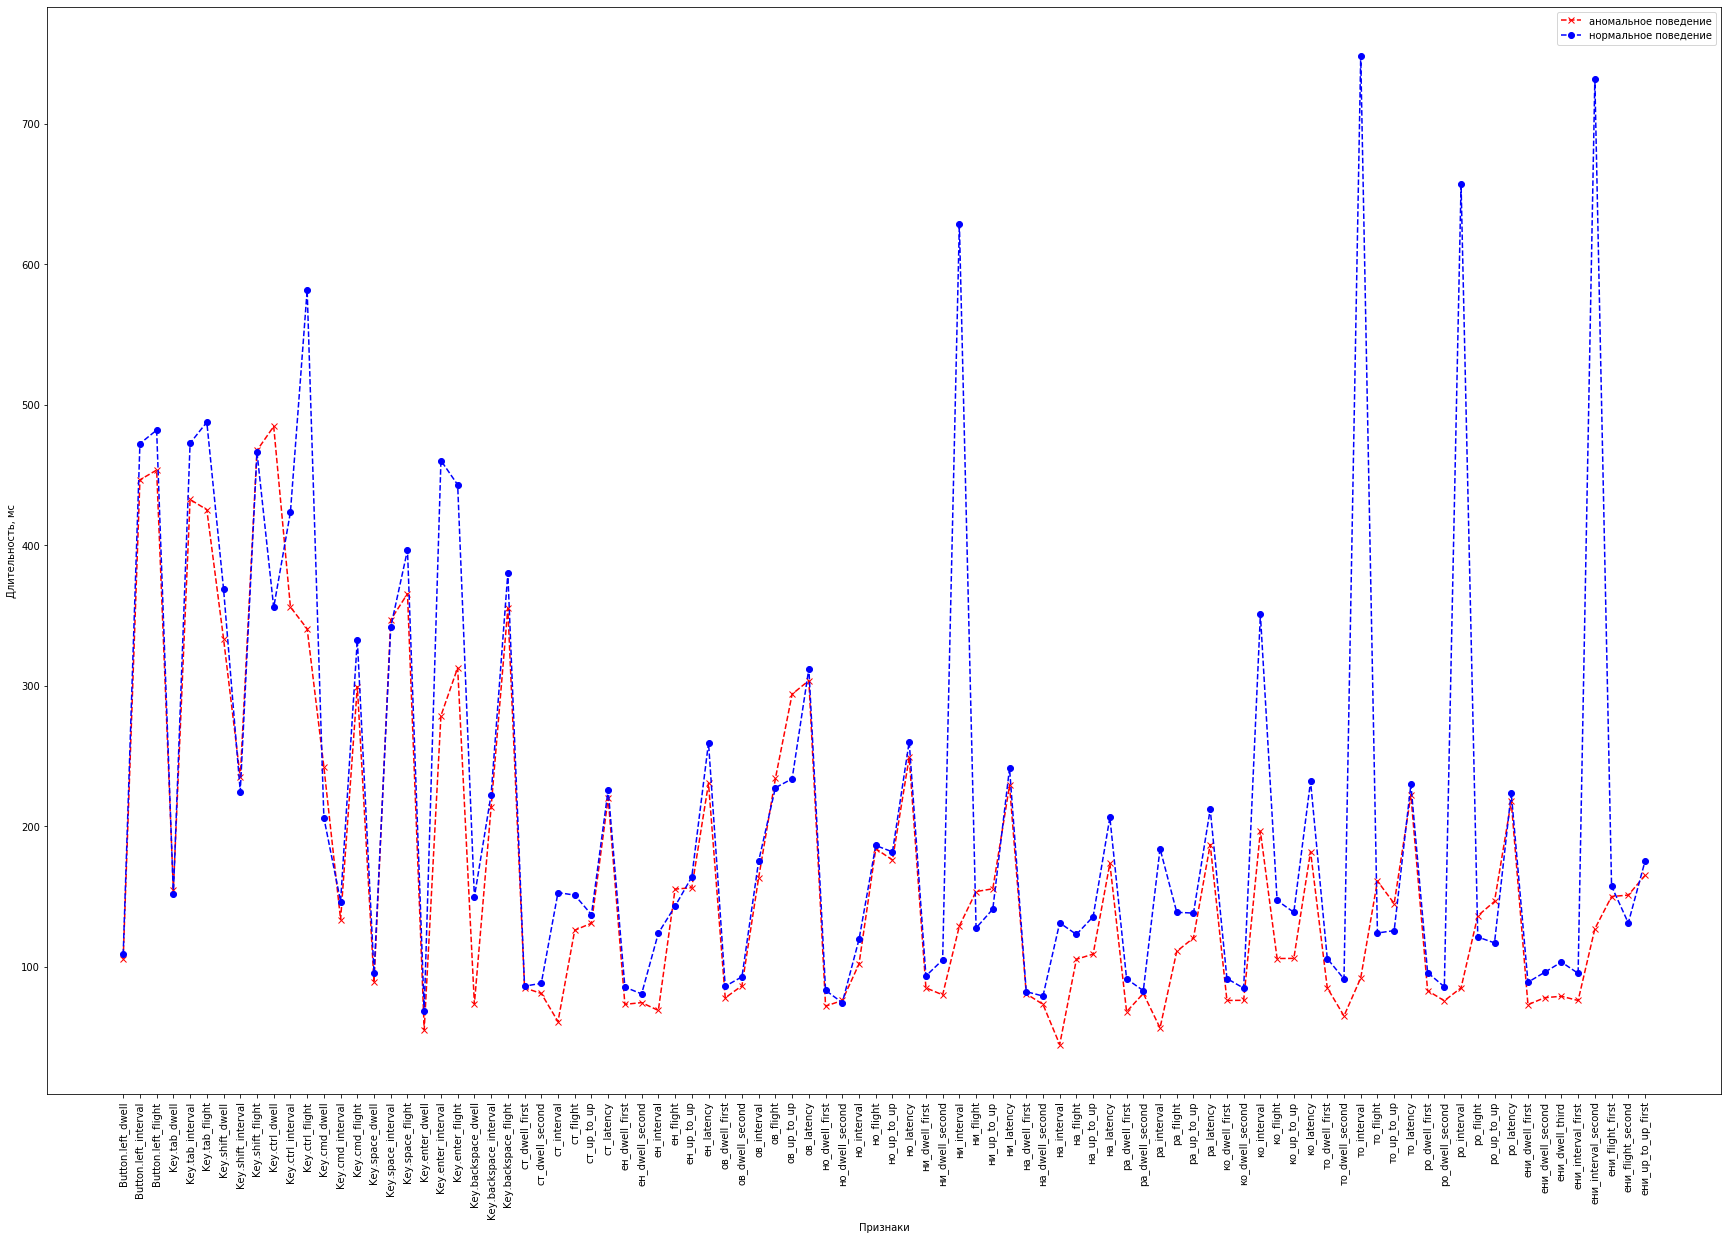

In [8]:
plt.figure(figsize=(30,20))
plt.plot(medians_insider[:92], '--rx', label = 'аномальное поведение')
plt.plot(medians_non_insider[:92], '--bo', label = 'нормальное поведение')
plt.legend()
plt.xticks(np.arange(len(cols)/2), labels=cols[:92], rotation=90)
plt.ylabel('Длительность, мс')
plt.xlabel('Признаки')
plt.savefig('first.png', bbox_inches='tight')
plt.show()

In [9]:
# удаление столбца is_insider из x_train и x_test
x_train.drop(columns = ['is_insider'], inplace = True)
x_test.drop(columns = ['is_insider'], inplace = True)
X_test.drop(columns = ['is_insider'], inplace = True)
x_train.head()

/Users/azamat/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Button.left_dwell,Button.left_interval,Button.left_flight,Key.tab,Key.tab_dwell,Key.tab_interval,Key.tab_flight,Key.shift,Key.shift_dwell,Key.shift_interval,...,тор_dwell_first,тор_dwell_second,тор_dwell_third,тор_interval_first,тор_interval_second,тор_flight_first,тор_flight_second,тор_up_to_up_first,тор_up_to_up_second,тор_latency
24,157.96,365.86,445.39,3.673469,111.13,186.07,297.20,0.244898,132.00,24.00,...,111.0,109.00,76.0,964.0,114.00,75.00,223.00,73.0,190.0,374.0
5,153.73,465.89,465.45,4.515648,188.22,466.55,496.36,2.101341,503.60,414.64,...,111.0,111.14,98.5,532.0,97.33,163.67,176.25,153.0,174.0,405.5
17,98.15,514.04,498.98,3.391304,154.41,432.52,425.25,4.695652,306.67,234.78,...,85.0,65.00,76.0,92.0,93.00,161.00,158.00,145.0,158.0,380.0
8,29.05,472.66,467.81,6.228814,149.64,482.15,478.73,0.127119,192.50,172.00,...,111.0,74.50,98.5,532.0,89.50,143.00,164.00,106.5,188.0,405.5
30,156.31,446.50,446.56,3.391304,154.41,432.52,425.25,4.433498,224.73,62.53,...,77.0,61.00,76.0,84.0,82.00,161.00,143.00,145.0,158.0,380.0


In [10]:
X_test.head(10)

,Button.left_dwell,Button.left_interval,Button.left_flight,Key.tab,Key.tab_dwell,Key.tab_interval,Key.tab_flight,Key.shift,Key.shift_dwell,Key.shift_interval,...,тор_dwell_first,тор_dwell_second,тор_dwell_third,тор_interval_first,тор_interval_second,тор_flight_first,тор_flight_second,тор_up_to_up_first,тор_up_to_up_second,тор_latency
0,94.25,477.76,422.48,0.201005,70.50,414.50,485.00,7.939698,261.86,142.48,...,136.0,149.00,92.0,984.00,975.00,120.00,124.00,133.00,67.00,336.0
1,38.48,503.40,467.41,0.622222,120.14,302.43,279.71,4.177778,486.64,244.15,...,77.5,74.00,77.5,106.00,102.50,183.50,176.50,180.00,180.00,437.5
2,127.38,413.77,433.62,4.434051,169.75,367.30,435.78,3.255379,495.26,388.29,...,129.0,182.00,120.0,973.50,964.00,102.50,146.00,155.50,84.00,368.5
3,98.57,441.08,477.79,0.648649,88.29,383.93,472.21,2.918919,402.27,374.73,...,80.0,74.00,58.0,95.50,102.50,175.50,176.50,169.50,160.50,410.0
4,158.74,398.98,406.21,0.404040,136.50,280.25,416.75,0.404040,544.75,237.00,...,136.0,106.50,121.5,958.00,90.00,94.00,196.50,64.50,211.50,412.0
5,48.41,477.83,476.66,0.525739,162.75,190.00,227.75,3.351588,397.90,272.04,...,65.0,31.00,89.0,142.00,315.00,207.00,346.00,173.00,404.00,642.0
6,146.20,443.25,453.64,0.878049,89.25,374.83,380.75,3.951220,402.06,202.63,...,103.0,89.67,99.0,970.67,67.67,73.67,157.33,60.33,166.67,330.0
7,252.58,458.51,480.32,0.504202,104.00,406.33,510.33,6.722689,183.07,121.33,...,78.0,70.00,74.0,85.50,87.00,163.50,157.00,155.50,161.00,394.5
8,120.28,490.19,451.39,3.391304,154.41,432.52,425.25,8.025478,337.90,229.71,...,85.0,65.00,76.0,92.00,93.00,161.00,158.00,145.00,158.00,380.0
9,66.85,503.83,473.12,10.080000,157.43,468.21,506.60,4.560000,377.05,285.68,...,85.0,65.00,76.0,92.00,93.00,161.00,158.00,145.00,158.00,380.0


### Метрики 

In [11]:
def report(clf, x_train, y_train, x_test, y_test, X_test, Y_test):
    y_pred = clf.fit(x_train, y_train).predict(x_test)
    Y_pred = clf.predict(X_test)
    print("accuracy train:", clf.score(x_train,y_train), "accuracy validation", accuracy_score(y_test, y_pred), "accuracy_test", accuracy_score(Y_test, Y_pred))
    print(classification_report(y_train, clf.predict(x_train)))    
    print(classification_report(y_test, y_pred))
    print(classification_report(Y_test, Y_pred))

### Модели

In [12]:
models = {
    'logistic regression': LogisticRegression(solver='lbfgs', random_state=0),
    'k-nearest neighbors': KNeighborsClassifier(n_neighbors=3),
    'naive bayes': BernoulliNB(),
    'support vector machines': SVC(kernel='linear', gamma='auto'),
    'random forest': RandomForestClassifier(max_depth=2, n_estimators = 200, random_state=0),
    'decision tree': DecisionTreeClassifier(),
    'adaptive boosting': AdaBoostClassifier(DecisionTreeClassifier(), algorithm="SAMME", n_estimators=200),
    'gradient boosting': GradientBoostingClassifier(n_estimators=200, learning_rate=1.0, max_depth=1, random_state=0),
    'multi-layer perceptron': MLPClassifier(alpha=0.001, max_iter=100000),
}

for k,v in models.items():
    print(k)
    report(v, x_train, y_train, x_test, y_test, X_test, Y_test)

logistic regression
accuracy train: 1.0 accuracy validation 1.0 accuracy_test 0.8125
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        11

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

              precision    recall  f1-score   support

           0       0.73      1.00      0.84         8
           1       1.00      0.62      0.77         8

    accuracy                           0.81        16
   macro avg       0.86      0.81      0.81

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        11

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22

              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.80      0.89         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10

              precision    recall  f1-score   support

           0       0.53      1.00      0.70         8
           1       1.00      0.12      0.22         8

    accuracy                           0.56        16
   macro avg       0.77      0.56      0.46        16
weighted avg       0.77      0.56      0.46        16



/Users/azamat/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
